thinking...
thinking...
thinking...

----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------
        
-----------------------------------------------
What Sensor Data Would You Like to Analysis?
        
1: Magentometer
2: Seismometer
x: Exit
        
*Exit for all menu's is 'x' or enter
-----------------------------------------------

Enter your choice (1-2, x): 1

------------------------------ A GUI icon shoud've appear in your task bar ------------------------------
---------------------------------------------------------------------------------------------------------
-------------------------- It is the file icon with the top right corner folded -------------------------
---------------------------------- Default file location is Downloadds ----------------------------------
-------------------------------------------------

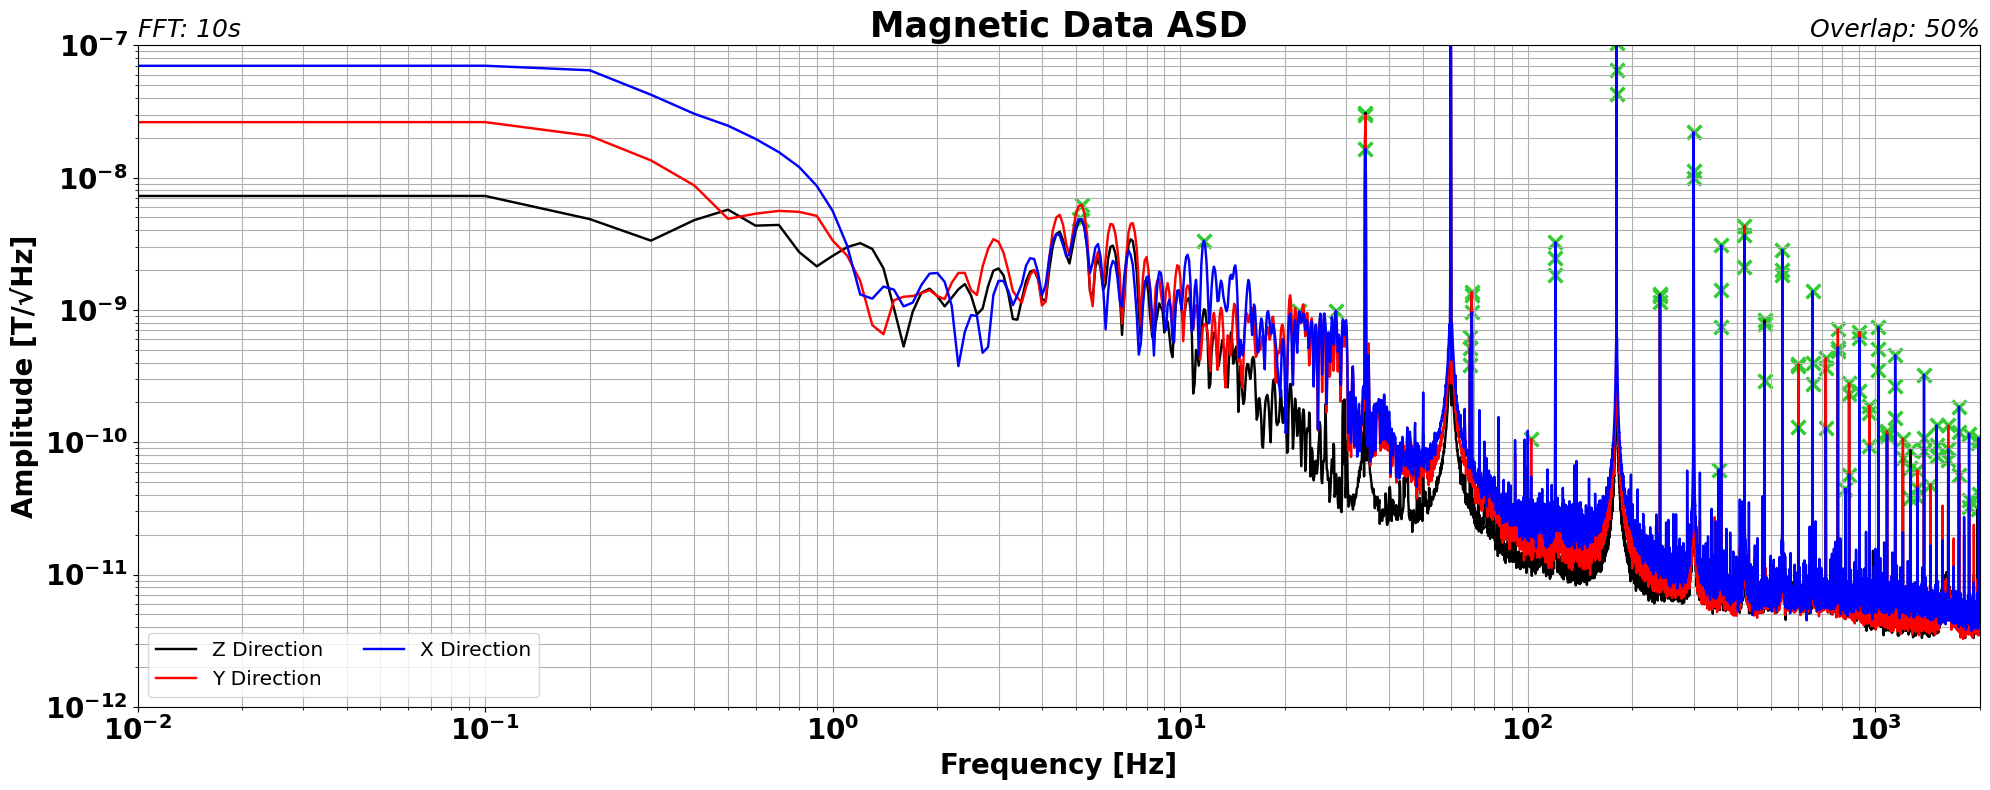


        
----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------

---------------------------------------
-- ASD Spectra Options --
0: Reset plot / FFT Parameters
1: Replot spectra
2: Compare to LIGO Hanford Data
3: Change plot limits / FFT Parameters
4: Look at specific times in the time series
5: Look at a specific frequency
x: Return to main menu
---------------------------------------
Enter your choice (0-5, x): 

Returning to main menu...

----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------
                
-----------------------------------------------
     === Magnetometer Analysis Menu ===
                       
         1: Plot Time Series
         2: Plot FFT

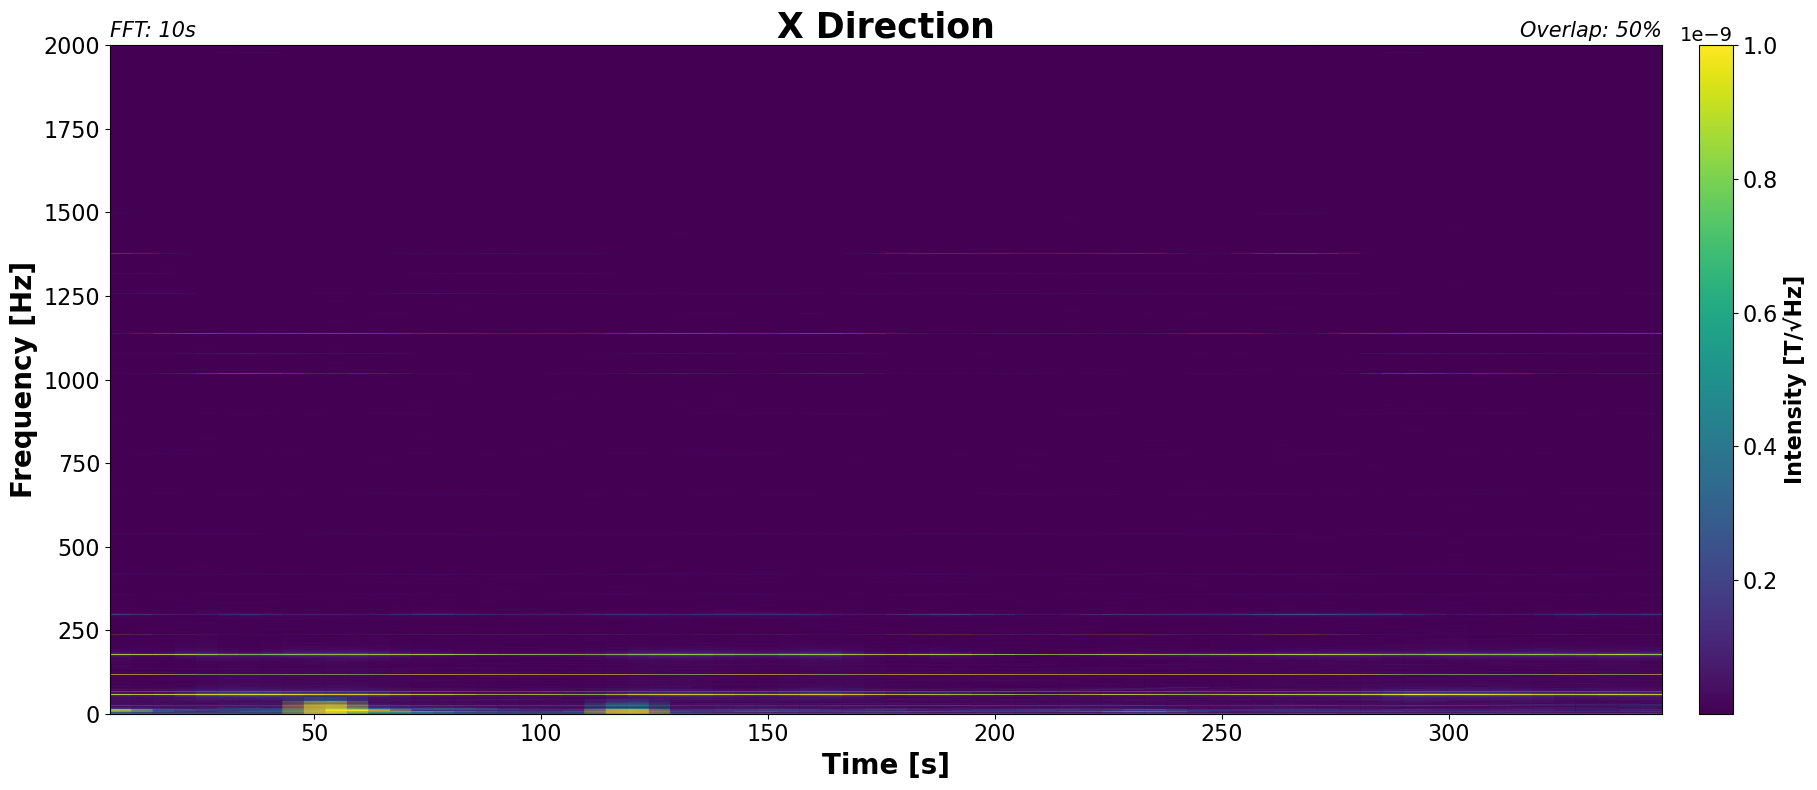

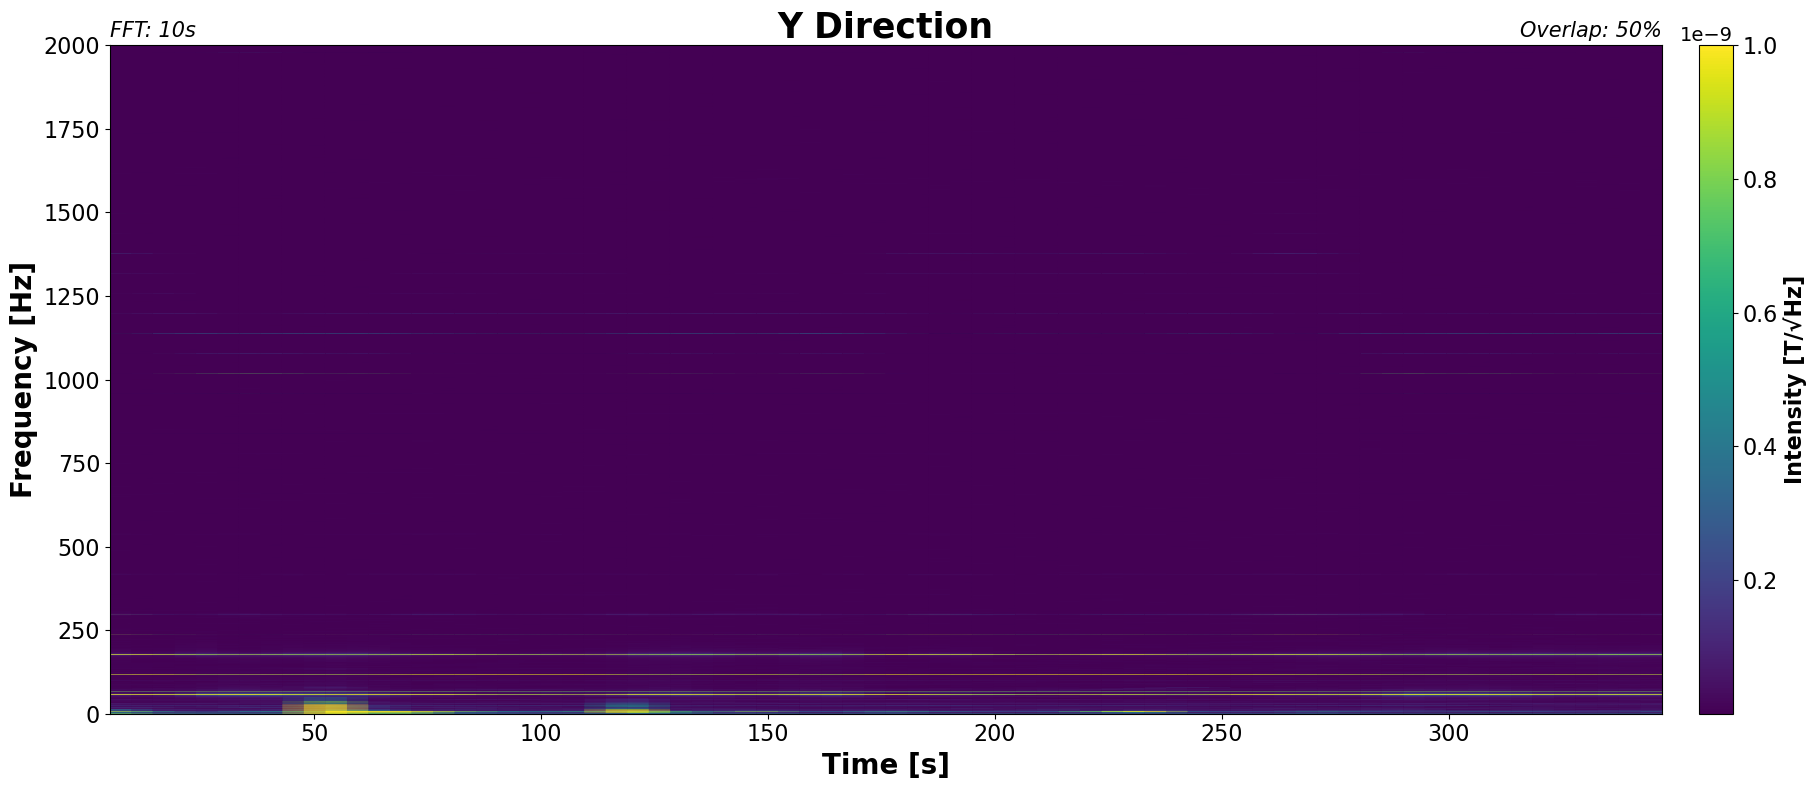

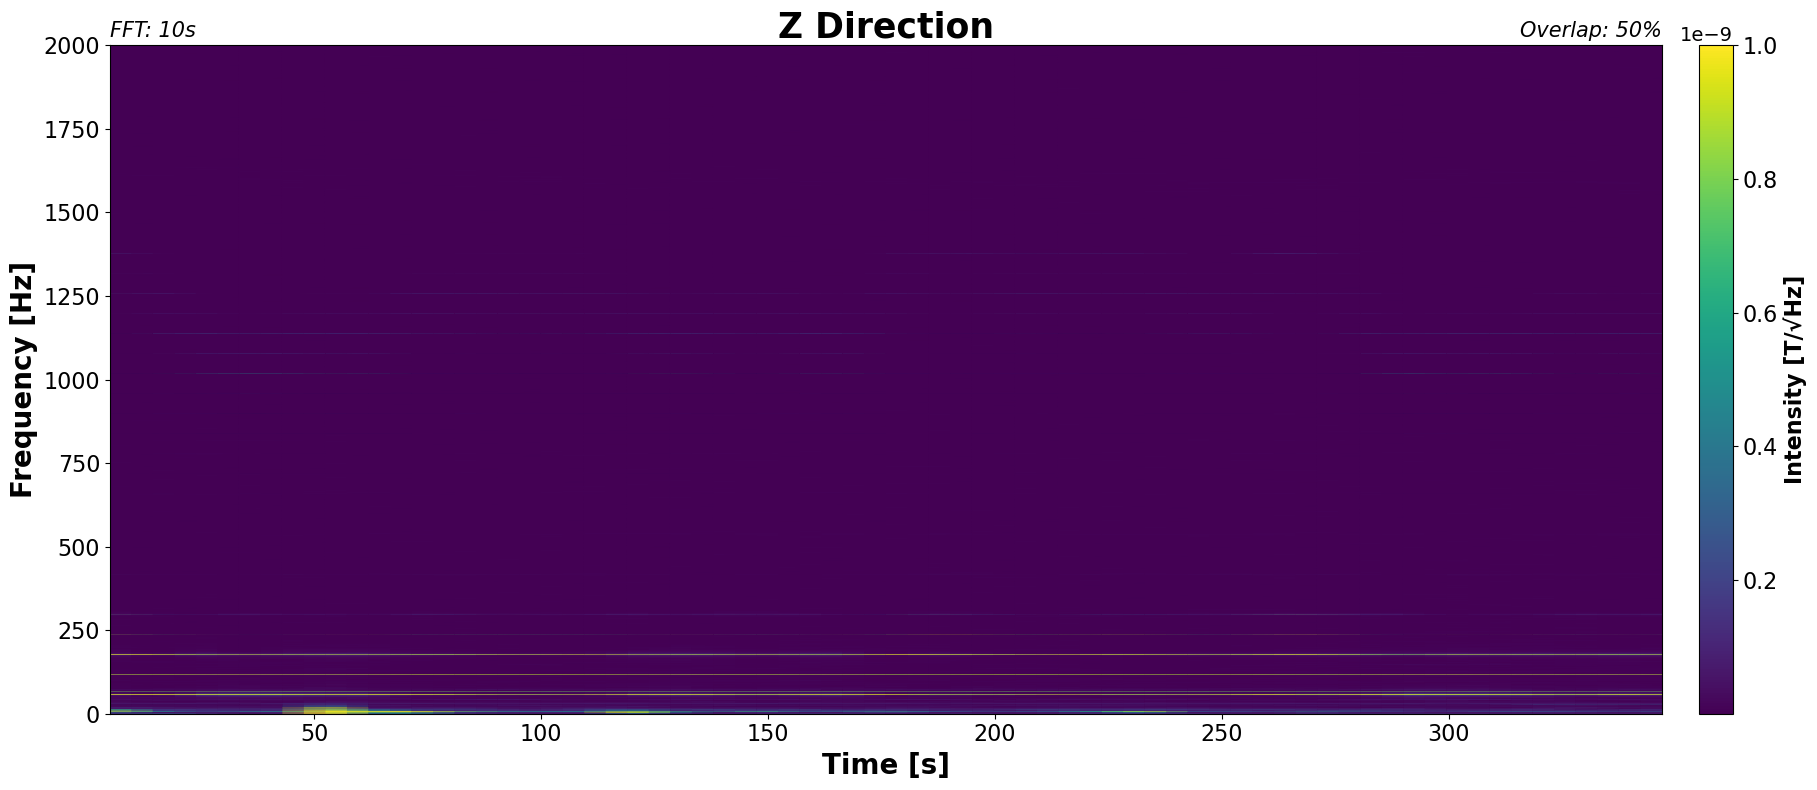


        
----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------

---------------------------------------
-- Spectrogram Options --
0: Reset plot / FFT Parameters
1: Replot spectrogram
2: Replot one axis
3: Change plot limits / FFT Parameters
x: Return to main menu
---------------------------------------

Enter your choice (0-3, x): 

Returning to main menu...

----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------
                
-----------------------------------------------
     === Magnetometer Analysis Menu ===
                       
         1: Plot Time Series
         2: Plot FFT Spectrum
         3: Plot Spectrogram
         x: Return to sensor menu
            

In [6]:
################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#
                                                                     
                 ##                                                        
                ####                ####   ####   #####  #####  #####        ##         ####     
               ######               #   #  #   #  #      #      #            #####      #   #  #   #  ####            
                 ##                 ####   ####   ####   #####  #####        ########   ####   #   #  #   #
                 ##                 #      #   #  #          #      #        #####      #   #  #   #  #   #
                 ##                 #      #   #  #####  #####  #####        ##         #   #   ###   #   #
                 ##

#------------------------------------------------------------------------------------------------------------------------------#
################################################################################################################################




################################################################################################################################
################################################################################################################################




'''
Sorry in advanced to whoever is trying to maintain or update this code. I tried to not use magic numbers
and annotate the best I could. 

Good luck and sorry for any potential headache.

- Carlos A. Campos

p.s. 
Yes, I know that I am extra about my commenting/organizing
'''

print("thinking...")  ## To periodical let the user the code is still running and hasn't hit a runtime error
import obspy
from obspy import UTCDateTime
import tkinter as tk
from tkinter import filedialog
from tkinter import PhotoImage
import pandas as pd
import numpy as np
print("thinking...")
from matplotlib import pyplot as plt
from scipy import signal
from matplotlib import gridspec
print("thinking...")
import matplotlib.ticker as mticker
import warnings  ## If warnings are still being printed out, just move the ignore line below whatever is causing the warning(s)
import os


'''##########################################################################################################################'''
'''##########################################################################################################################'''

                                 ####  ######  #   #       #####  ###  #      #####  #####
                                #      #       #   #       #       #   #      #      #
                                #      ######  #   #       ###     #   #      ###    #####
                                #           #   # #        #       #   #      #          #
                                 ####  ######    #         #      ###  #####  #####  #####
                    
'''##########################################################################################################################'''
'''##########################################################################################################################'''
    
    

def csv_upload(function):  ## Function to upload CSV files from the WebDAQ
    
    result = {"path": None}
    
    print("\n------------------------------ A GUI icon shoud've appear in your task bar ------------------------------")
    print("---------------------------------------------------------------------------------------------------------")
    print("-------------------------- It is the file icon with the top right corner folded -------------------------")
    print("---------------------------------- Default file location is Downloadds ----------------------------------")
    print("---------------------------------------------------------------------------------------------------------")
    print("---------------------- Select that to pick the data file you would like to analyze ----------------------\n")

    

    def upload_file():

        ## file selection 
        result["path"] = filedialog.askopenfilename(title="Select a file", filetypes=[("All Files", "*.csv")]) 
        
        ## You can changge it to just open .csv files via:
        #       filetypes=[("CSV Files", "*.csv")] 

        print(f"\nFile selected: " + result["path"]) ## Prints out data path as a sanity check
        print("\n----------------------------------------------------------------------------------------------------------")
        print("-------------------------------------- Close the GUI program window --------------------------------------")
        print("----------------------------------------------------------------------------------------------------------")

    root = tk.Tk()
    root.title("File Uploader")

    ## This was to give the GUI a custom icon. It kind of worked on linux. But, didn't work on windows.
    ## kept it in just in case
    '''
    icon_path = os.path.join(os.getcwd(), 'ce_gui_icon.png')

    try:
        icon = tk.PhotoImage(file=icon_path)
        root.iconphoto(True, icon)

        if os.name == 'nt':  # Only works outside Jupyter
            root.iconbitmap(icon_path.replace(".png", ".ico"))

    except Exception as e:
        print(f"Could not set icon: {e}")
    '''

    label = tk.Label(root, text="Select field data", font=("Arial", 10))
    label.pack(padx = 30)

    upload_button = tk.Button(root, text="Upload File", command=upload_file) ## Create button txt 
    upload_button.pack(pady = 30, padx = 50)

    root.mainloop() ## Runs the GUI
    
    file_path = result["path"]
    
    if not file_path:
        print("No file selected. Returning to menu.")
        return None
    
    print("thinking...")

    ## Selects info from metadata 
    metadata_rows = []
    metadata = {}

    with open(file_path, 'r') as f:
        for _ in range(5):
            metadata_rows.append(f.readline().strip()) 

    for row in metadata_rows:
        if ':' in row: 
            key, value = row.split(':', 1)
            metadata[key.strip()] = value.strip()

#-----------------------------------------# This is the sample rate from the metadata #----------------------------------------#

    sample_rate = float(metadata["Sample Rate"])
    print("\nSample Rate: " + metadata["Sample Rate"]) ## sanity check

#------------------------------------------------------------------------------------------------------------------------------#

    print("thinking...")

    if function == "mag":
        columns = ["Sample", "Time (s)", "Noise (V)", "Voltage X (V)", "Voltage Y (V)", "Voltage Z (V)", "blank"]
        calibration = (1.222e-05)/21
        ctrl_calibration = (1.222e-05)/21
        control_file = 'mag_data.csv'  ## If the ctrl/LIGO file is changed, put the new file name here
        
    elif function == "seis":
        columns = ["Sample", "Time (s)", "Noise (V)", "Channel E (V)", "Channel N (V)", "Channel Z (V)", "blank"]
        calibration = (0.0125e-1)/21
        ctrl_calibration = 0.0076e-6
        control_file = 'ligo_seis_data.txt'
        
    else:
        print("oops") 
    
#------------------------------------------------------------------------------------------------------------------------------#
    
    data = pd.read_csv(file_path, skiprows = 6, delimiter=',') 

    data.columns = columns

    time   = data[columns[1]]
    #noise  = data[columns[2]] * calibration  ## The noise channel can be added into the other plots
                                              ## However, it is not regularly looked at, that is why it is commented out
    x_axis = data[columns[3]] * calibration # east
    y_axis = data[columns[4]] * calibration # north    
    z_axis = data[columns[5]] * calibration
    
#------------------------------------------------------------------------------------------------------------------------------#

    print("thinking...")
    
    script_dir = os.getcwd()                                    ## Python searches thru the comp's OS
    control_data_path = os.path.join(script_dir, control_file)  ## to find the respective ctrl file
    if os.path.exists(control_data_path):
        

        if control_file == 'ligo_seis_data.txt':
            huddle = pd.read_csv(control_data_path, delimiter="\s+")
            huddle.columns = ["frequency", "x", "y", "z"]

            ctrl_freq = huddle["frequency"]
            ctrl_x = huddle["x"] * ctrl_calibration
            print("thinking...")
            ctrl_y = huddle["y"] * ctrl_calibration
            ctrl_z = huddle["z"] * ctrl_calibration
            
            return sample_rate, time, x_axis, y_axis, z_axis, ctrl_x, ctrl_y, ctrl_z, ctrl_freq

        elif control_file == 'mag_data.csv':

            ligo = pd.read_csv(control_data_path, delimiter=",", skiprows=5)
            #ligo.columns = ["Sample", "Time (s)", "Voltage X (V)", "Voltage Y (V)", "Voltage Z (V)"]
            

            ctrl_z = ligo['Voltage Z (V)'][0:647487] * calibration   ## the data is shorter then the other two
            ctrl_y = ligo['Voltage Y (V)'] * calibration
            ctrl_x = ligo['Voltage X (V)'] * calibration
            ctrl_sr = 5120
            
            return sample_rate, time, x_axis, y_axis, z_axis, ctrl_x, ctrl_y, ctrl_z, ctrl_sr

    else:
        print("Control data not found\n")
        return sample_rate, time, x_axis, y_axis, z_axis, None, None, None, None
        


    
'''##########################################################################################################################'''
'''##########################################################################################################################'''

                        #######  #####  #####  #####  ####        #####  ###  #      #####  #####
                        #  #  #  #      #      #      #   #       #       #   #      #      #
                        #  #  #  #####  ###    ###    #   #       ###     #   #      ###    #####
                        #  #  #      #  #      #      #   #       #       #   #      #          #
                        #     #  #####  #####  #####  ####        #      ###  #####  #####  #####

'''##########################################################################################################################'''
'''##########################################################################################################################'''




file_paths_global = []

def mseed_upload():  ## function to upload miniseed files from the Minimus
    
    def get_valid_datetime(prompt):  ## checks to make sure the user inputted a valid time
        while True:
            date_input = input(prompt)
            if date_input == "" or date_input == "" or date_input == "none" or date_input == "x"or date_input == "X":
                return None
            try:
                return UTCDateTime(date_input)
            except Exception as e:
                print(f"Invalid date/time format: {e}")
                print("Please enter the date/time in the correct format (e.g., 2020-01-01T00:00:00)")
                print("You can also enter '' to put no time constrant")

            
    print("\n------------------------------ A GUI icon shoud've appear in your task bar ------------------------------")
    print("---------------------- Select that to pick the data file you would like to analyze ----------------------\n")

    def upload_files(): ## Function for GUI
        global file_paths_global 

        file_paths_global = filedialog.askopenfilenames(title="Select files", filetypes=[("All Files", "*.*")])

        if file_paths_global:
            for file_path in file_paths_global:
                print(f"File selected: {file_path}") 
            print("\n---------------------------------------Close the GUI program window---------------------------------------")
        else:
            print("No files selected.")


    root = tk.Tk()
    root.title("Multi File Uploader GUI")
    #icon = PhotoImage(file="ce_gui_image.png")
    #root.iconphoto(False, icon)

    upload_button = tk.Button(root, text="Upload mseed flie", command=upload_files)
    upload_button.pack(pady=15)

    root.mainloop() ## Runs the application 
    
    if not file_paths_global:
        print("No file selected. Returning to menu.")
        return None

    paths = sorted(file_paths_global) ## sorts paths alphabetically and saves it to a variable   
    
    print("thinking...")


    ## This was going to be so the user can see the start and end time(s). However, the Minimus will default to the same
    ## date if the GPS is not connected. So, it's start and end time(s) are often inaccurate. So, make sure the Minimus is getting
    ## a GPS signal when taking data

    '''
    alpha = obspy.read(file_paths_global[0])
    beta = obspy.read(file_paths_global[1])
    gamma = obspy.read(file_paths_global[2])

    print("File 1: Start time: " + str(alpha[0].stats.starttime) + " End time:" + str(alpha[0].stats.endtime) )
    print("File 2: Start time: " + str(beta[0].stats.starttime) + " End time:" + str(beta[0].stats.endtime) )
    print("File 3: Start time: " + str(gamma[0].stats.starttime) + " End time:" + str(gamma[0].stats.endtime) )
    '''    


    print("\nEnter the start and end times wish to look at")
    print("\nThe format should be like this:\n\n2020-01-01T00:00:00")

    start = get_valid_datetime("Start date and time: ")
    end = get_valid_datetime("End date and time: ")
    
    if start is not None:
        start_time = UTCDateTime(start)
    else:
        start_time = start  ## if start is none, it will start at the beginning of the file
    if end is not None:
        end_time = UTCDateTime(end)
    else:
        end_time = end  ## if end is none, it go to the end of the file

    ##
    '''
    if both are none, then it will plot/calculate over the entire file. These calculations will take a while and the plots
    will be dense. I advise NOT do this. This is so the user can escape the time input lines; 
    if they don't want to input a time
    '''
    ##

    def process_multiple_miniseed(file_paths, start_time=None, end_time=None):
    
        sample_rates_all = []
        times_all = []       ## Variables for the function 
        data_values_all = []

        for idx, file_path in enumerate(file_paths):
            print(f"\nProcessing file {idx+1}: {file_path}")

            st = obspy.read(file_path) #---------------------------- Reads the MiniSEED file ----------------------------------#

            try:
                print(f"Filtering data between {start_time} and {end_time}")
                st = st.trim(starttime=start_time, endtime=end_time)
            except Exception as e:
                print(f"Error trimming data: {e}")
                continue      

            if len(st) == 0: ## Check if any traces remain after trimming
                print(f"No data available in the specified time range for file: {file_path}")
                continue
            
            print("thinking...")

            sample_rates = []
            times = []         ## lists for the current file's trace(s) 
            data_values = []

#---------------------------------------- Process each remaining trace in the file --------------------------------------------#

            for trace in st:

                sample_rates.append(trace.stats.sampling_rate) #---------- Append trace data to lists for this file -----------#
                times.append(trace.times())                    #--------------# Relative times for each sample #---------------#
                data_values.append(trace.data)

            sample_rates_all.append(sample_rates)
            times_all.append(times)                ## Append the current file's trace data to the overall lists
            data_values_all.append(data_values)

#----------------------------------------------- Assigns variables for each file ----------------------------------------------#

        sample_rates1, sample_rates2, sample_rates3 = sample_rates_all
        times_e, times_n, times_z = times_all
        data_e, data_n, data_z = data_values_all

        print("thinking...")

        return data_e, data_n, data_z, times_e, times_n, times_z, sample_rates1  ## The sample rates are the same

#-------------------------------------------------------- Runs function -------------------------------------------------------#

    print("thinking...")

    data_e, data_n, data_z, times_e, times_n, times_z, sr = process_multiple_miniseed(paths, start_time = start_time, 
                                                                                      end_time = end_time)
    
    time_e = times_e[0]
    time_n = times_n[0]
    time_z = times_z[0]
    
    z = data_z[0] * 0.0015e-6 ## This the conversion factor for turning the data into m/s 
    n = data_n[0] * 0.0015e-6 
    e = data_e[0] * 0.0015e-6


#-----------------------------------------# This is the sample rate from the metadata #----------------------------------------#

    sr =  sr[0]
    print("\nSample rate: " + str(sr))

#------------------------------------------------------------------------------------------------------------------------------#

    script_dir = os.getcwd()
    control_data_path = os.path.join(script_dir, 'ligo_seis_data.txt')

    if os.path.exists(control_data_path):
        huddle = pd.read_csv(control_data_path, delimiter="\s+")

        huddle.columns = ["frequency", "x", "y", "z"]

        hf = huddle["frequency"]
        hx = huddle["x"] * 0.0076e-6
        hy = huddle["y"] * 0.0076e-6 
        hz = huddle["z"] * 0.0076e-6

    else:
        print("LIGO data not found\n")
        hx = hy = hz = hf = None
    
    return e, n, z, time_e, time_n, time_z, sr, hx, hy, hz, hf



    
'''##########################################################################################################################'''
'''##########################################################################################################################'''

    #   #   ###   ####   ###   ###   ####   #      #####       #####  #####  #      #####   ####  #####  ###   ###   ##    #
    #   #  #   #  #   #   #   #   #  #   #  #      #           #      #      #      #      #        #     #   #   #  # #   #
    #   #  #####  ####    #   #####  ####   #      ###         #####  ###    #      ###    #        #     #   #   #  #  #  #
     # #   #   #  #   #   #   #   #  #   #  #      #               #  #      #      #      #        #     #   #   #  #   # #
      #    #   #  #   #  ###  #   #  ####   #####  #####       #####  #####  #####  #####   ####    #    ###   ###   #    ##
    
'''##########################################################################################################################'''
'''##########################################################################################################################'''




def get_optional_float(prompt, func, ID, sensor, time, allow_back=True):
    
    
    '''
    This is a function to make sure that the code doesn't crash if the user
    inputs a value or string that will cause an error.

    If the user inputs one of these values, the function will tell them the
    input is invalid and what is allowed

    Each function has it's own set of paramaters. These parameter return 
    different values depending on the user input and sensor selected
    '''

    
    defaults = {
        "time_series": {
            "x_min": {"default": 0},

            "x_max": {"default": lambda time: time[len(time) - 1]},
           
            "other": {"default": None}
        },

        ## ------------------------------------------------------------------- ##

        "asd": {
            "fft_len": {"default": {"seis": 128,    ## if fun == seis 
                                    "mag": 10}},

            "overlap": {"default": 50},

            "my_max": {"default": 1e-7,
                       "none": None},

            "my_min": {"default": 1e-14,
                       "none": None},

            "y_max": {"default": {"seis": 1e-6, 
                                  "mag": 1e-7}},
                                  
            "y_min": {"default": {"seis": 5e-11, 
                                  "mag": 1e-13}},

            "x_max": {"default": {"seis": 100, 
                                  "mag": 2000},
                      "none": None},

            "x_min": {"default": {"seis": 0.1, 
                                  "mag": 0.05},
                      "none": None},

            "prominence": {"default": {"seis": 5, 
                                       "mag": 2.25},
                           "none": None},
                            
            "frequency": {},

            "start_time": {"default": 0},
            
            "end_time": {"default": -1}
        },

        ## ------------------------------------------------------------------- ##

        "spectrogram": {
            "fft_len": {"default": 10},

            "overlap": {"default": 50},

            "y_max": {"default": {"seis": 100, 
                                  "mag": 2000}},
                                  
            "y_min": {"default": 0},

            "x_max": {"default": None},
            
            "x_min": {"default": None},

            "c_min": {"default": {"seis": 1e-9, 
                                  "mag": 1e-13}},

            "c_max": {"default": {"seis": 1e-8, 
                                  "mag": 1e-9}},
            "axis": {}
        }
    }


#------------------------------------------------------------------------------------------------------------------------------#


    while True:
        user_input = input(prompt).strip().lower()

        if allow_back and user_input == "x":              ## this will send the user back to the previous menu
            return "BACK"

        ## selects:         function dict     ID dict       and  value       anything not listed
        param_rules = defaults.get(func, {}).get(ID, defaults.get(func, {}).get("other", {}))

        if user_input in ["none", "", "default"]:
            val = param_rules.get(user_input) or param_rules.get("default")

            '''
            Some of the ID's have "none" and "default" return different values, and some retun the same value.
            This makes it so if "none" is listed, it will select the None value. If "none" is not listed in the
            dictionary, or if "" is entered, it will select the "default" value listed. 
            '''

            if callable(val):
                return val(time)          ## for the lambda function
            
            elif isinstance(val, dict):
                return val.get(sensor)    ## returns value based on func value
            
            else:
                return val

        ## If the user inputs something not listed it will return the print line and not crash
        try:
            return float(user_input)
        except ValueError:
            print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")

                    
#------------------------------------------------------------------------------------------------------------------------------#
################################################################################################################################





'''##########################################################################################################################'''
'''##########################################################################################################################'''

                              #####  #   #######   #####     #####  #####  ####    #  #####  #####
                                #    #   #  #  #   #         #      #      #   #   #  #      #    
                                #    #   #  #  #   ###       #####  ####   ####    #  ###    #####
                                #    #   #  #  #   #             #  #      #   #   #  #          #
                                #    #   #     #   #####     #####  #####  #   #   #  #####  #####

'''##########################################################################################################################'''
'''##########################################################################################################################'''




def plot_time_series(time, x, y, z, function):
    print("Running time series plot...")
    
    def time_series(channels, t, zed, north, east, xmax, xmin, ymax, ymin, function):
        
        
        title = "Seismic"
        labels = ['E', 'N', 'Z']
        y_label = "Amplitude (m/s)"

        t0, t1, t2 = t, t, t
            
        if function == "mag":
            title = "Magnetic"
            labels = ['X', 'Y', 'Z']
            y_label = "Amplitude [T]"

        elif function == "mini":

            # Axises       E     N     Z
            t0, t1, t2 = t[0], t[1], t[2]

        channel_map = {
            '1': [(title, labels[2], zed, t2 , 'black'), 
                  (title, labels[1], north, t1 , 'red'), 
                  (title, labels[0], east, t0, 'blue')],    ## All Axises

            '2': [(title, labels[0], east, t0, 'blue')],    ## X / E Axis
            '3': [(title, labels[1], north, t1, 'red')],    ## Y / N Axis
            '4': [(title, labels[2], zed, t2, 'black')],    ## Z Axis
        }

        ## ------------------------------------------------------------------------------------- ##

        if channels == "0":
            for data, label, t, colors in zip([east, north, zed],
                                               labels, 
                                              [t0, t1, t2],
                                              ['blue', 'red', 'black']):
                
                plt.figure(figsize = (20,8))
                ax = plt.gca()
                ax.yaxis.get_offset_text().set_fontsize(16)

                plt.plot(t, data, linewidth = 1.5, color = colors, label = label)

                plt.title(title + " Channel: " + label, fontweight = 'bold', fontsize = 25)
                plt.xlabel("Time (s)", fontweight = "bold", fontsize = 20)
                plt.ylabel(y_label, fontweight = "bold", fontsize = 20)

                plt.xlim(xmin, xmax)
                plt.ylim(ymin, ymax)
                
                plt.yticks(fontsize = 20, fontweight = "bold")
                plt.xticks(fontsize = 20, fontweight = "bold")
                
                plt.legend(loc = "upper right", fontsize = 18)
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            return

        ## ------------------------------------------------------------------------------------- ##        

        plt.figure(figsize = (20,8))
        ax = plt.gca()
        ax.yaxis.get_offset_text().set_fontsize(16)
            
        for plot_title, label, data, t , color in channel_map[channels]:

            plt.plot(t, data, linewidth = 1.5, color = color, label = label)
            if channels != '1':
                plt.title(plot_title + " Channel: " + label, fontweight = 'bold', fontsize = 25)

        if channels == '1':
            plt.title(title + " Data Time Series", fontweight = 'bold', fontsize = 25)

        
        plt.xlabel("Time (s)", fontweight = "bold", fontsize = 20)
        plt.ylabel(y_label, fontweight = "bold", fontsize = 20)

        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

        plt.yticks(fontsize = 20, fontweight = "bold")
        plt.xticks(fontsize = 20, fontweight = "bold")
        
        plt.legend(loc = "upper right", fontsize = 18)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    x_min = 0

    if function == "mini":
        x_max = time[0][len(time[0]) - 1]
    else:
        x_max = time[len(time) - 1]


    if function == "mag":
        time_series("0", time, z, y, x, x_max, x_min, None, None, function)
        amp = "[T]"
    
    elif function == "seis" or function == "mini":
        time_series("1", time, z, y, x, x_max, x_min, None, None, function)
        amp = "[m/s]"
        


################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#

    while True:
        # In Jupyter the place of the input line is not consistent. So, sometimes it is printed out before the option list.
        # To fix this, the option list was placed into the input line, so that everything is alway together.

        sub_choice = input("""
        
----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------

---------------------------------------
         -- Zoom in Menu --

1: Zoom in on specific time range
x: Return to main menu
---------------------------------------

Enter your choice (1, x): """)

        #print("2: Save plot to file")                   # -- Maybe later

        if sub_choice == "1":
            
            t = time
            if function == 'mini':
                t = time
            print("\nWhat x limits do you want (You can input None)") 
            x_min = get_optional_float("Lower bound [s]: ", "time_series", 'x_min', None, t)
            if x_min == "BACK":
                return
            
            x_max = get_optional_float("Upper bound [s]: ", "time_series", 'x_max', None, t[0])
            if x_max == "BACK":
                return
            
            ## ------------------------------------------------------------------------------------- ##
        
            print("\nWhat y limits do you want (You can input None)")
            y_min = get_optional_float("Lower bound " + amp + ": ", "time_series", None, None, time)
            if y_min == "BACK":
                return

            y_max = get_optional_float("Upper bound " + amp + ": ", "time_series", None, None, time)
            if y_max == "BACK":
                return
            
################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#

            while True:
                
                channel = input("""
                
----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------

---------------------------------------
Which channel(s) do you wish to look at?
1: All three
2: East
3: North
4: Z
0: Reset plot limits
x: Return to Zoom in Menu
---------------------------------------

Enter your choice (1-4, x): """)

################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#
               
                if channel == "0":
            
                    x_min = 0
                    if function == "mini":
                        x_max = time[0][len(time[0]) - 1]
                    else:
                        x_max = time[len(time) - 1]
                    y_max = None
                    y_min = None

                    print("\n\nPlot limits reset")

                    
                ## ------------------------------------ All Channel ------------------------------------ ##
                elif channel == "1":
                    if function == "mag":
                        time_series("0", time, z, y, x, x_max, x_min, y_max, y_min, function)

                    elif function == "seis" or function == "mini":
                        time_series(channel, time, z, y, x, x_max, x_min, y_max, y_min, function)


                ## ------------------------------------- X Channel ------------------------------------- ##
                elif channel == "2":
                    time_series(channel, time, z, y, x, x_max, x_min, y_max, y_min, function)
                    

                ## ------------------------------------- Y Channel ------------------------------------- ##
                elif channel == "3":
                    time_series(channel, time, z, y, x, x_max, x_min, y_max, y_min, function)
                    

                ## ------------------------------------- Z Channel ------------------------------------- ##
                elif channel == "4":
                    time_series(channel, time, z, y, x, x_max, x_min, y_max, y_min, function)

                    
#------------------------------------------------------------------------------------------------------------------------------#
                elif channel == "x" or channel == "":
                    print("\nReturning to Time Series Options...")
                    break
                    
                else:
                    print("\nInvalid input. Try again.")
    
################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#

        elif sub_choice == "x" or sub_choice == "":
            print("\nReturning to main menu...")
            break
        else:
            print("\nInvalid input. Try again.")    


            
            
'''##########################################################################################################################'''            
'''##########################################################################################################################'''

                                   #####  ####   #####   ####  #####  ####    #    #  #######
                                   #      #   #  #      #        #    #   #   #    #  #  #  #
                                   #####  ####   ####   #        #    ####    #    #  #  #  #
                                       #  #      #      #        #    #   #   #    #  #  #  #
                                   #####  #      #####   ####    #    #   #    ####   #     #
                    
'''##########################################################################################################################'''
'''##########################################################################################################################'''




def plot_spectrum(time, sr, x, y, z, ligo_freq, ligo_sr, ligo_x, ligo_y, ligo_z, function):
    print("Plotting Spectrum...")
    

    
    
################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#
#----------------------------------------- The ASD is calculated via welch from scipy -----------------------------------------#
#------------------------------------------------------------------------------------------------------------------------------#
################################################################################################################################

    warnings.simplefilter('ignore')
    
    '''
    This the function that calculates the ASD spectra of the data acquired. A Power Specral Density (PSD) plot is calculated
    first via signal.welch from scipy. Next the square root of this data is taken to turn it into an Amplitude Spectral
    Density (ASD) plot. Next signal peaks are found to see what frequencies are present in the data. This process can be
    refined much further. After those are found everything is plotted togther

    The control/ligo data for the seismometer was acquired from the LIGO Hanford Observatory (LHO) as a ready to plot 
    function. However, for the magnetometer, we took data with our setup to ensure the sensitivity was the same. So, that means
    that an additional ASD has to be calculated for the control data. 
    '''
    def asd(data_z, data_n, data_e, sample_rate, lf, lx, ly, lz, bart_sample_rate, bart_x, bart_y, bart_z, frequency,
        over_lap, fft, signal_prom, ymin, ymax, xmin, xmax, func, channel):
    
#------------------------------------------------------------------------------------------------------------------------------#
    
        '''
        There are two methods of finding peaks because when looks for peaks across the entire spectrum,
        while the other looks at one section. This section is determined by the desired frequency the
        user wishes to look at +- 1. So, if the user wants to look at 60Hz, the range would be 59-61 Hz.
        '''
        
        def peaks(signal_freq, signal_log, frequency, signal_prom):
                tolerance = 1

                if frequency is None:
                    peak, _ = signal.find_peaks(signal_log,
                                                prominence = signal_prom)
                
                else:
                    mask = (signal_freq >= frequency - tolerance) & (signal_freq <= frequency + tolerance)
                    peaks_local, _ = signal.find_peaks(signal_log[mask], prominence = signal_prom)

                    peak = np.where(mask)[0][peaks_local]

                return peak

#------------------------------------------------------------------------------------------------------------------------------#

        def spectrum(data, sr):
            f, Pxx = signal.welch(data, sr, window = 'hamming',
                                nperseg = sr * fft,
                                noverlap = round(sr * (over_lap * 0.01)))
                                
            return f, np.sqrt(Pxx)

#------------------------------------------------------------------------------------------------------------------------------#
        
        input_data = {'z': data_z,          ## Dictionary for direction and field data
                    'n': data_n,
                    'e': data_e}

        results = {}                        ## Dictionary for dirct and calculations

        ## ------------------------------------------------------------------------------------- ##

        for key, data in input_data.items():
            if data is None:
                continue

            signal_f, amp = spectrum(data, sample_rate)
            log_amp = np.log(amp)

            if func == 'displacement':
                disp = amp / (2 * np.pi * signal_f) 
            else: 
                disp = None

            peak_gquux = peaks(signal_f, log_amp, frequency, signal_prom)
            
            results[key] = {'frequency': signal_f,
                            'amp': amp,
                            'disp': disp,
                            'peaks': peak_gquux}

        ## ------------------------------------------------------------------------------------- ##

        if bart_sample_rate is not None:

            ref_data = {'x': bart_x, 'y': bart_y, 'z': bart_z}
            ref_out = {}
            
            for key, data in ref_data.items():
                if data is not None:

                    lf, amp = spectrum(data, bart_sample_rate)
                    ref_out[key] = amp
            
            lx, ly, lz = ref_out.get('x'), ref_out.get('y'), ref_out.get('z')

        ## ----------------- Dictionaries for plotting depending on direction ------------------ ##
        
        color_map = {'z': 'black', 
                    'n': 'red', 
                    'e': 'blue'}

        ctrl_map   = {'z': lz,
                    'n': ly, 
                    'e': lx}

        title_map = {'z': drctn_title[2], 
                    'n': drctn_title[1], 
                    'e': drctn_title[0]}
        
        ## ------------------------------------------------------------------------------------- ##
            
        if func == 'velocity':
            ylabel = v_label 
            title = v_title

        else:
            ylabel = s_label
            title = s_title


        if channel == 'all':
            channels_to_plot = ['z', 'n', 'e']

        else:
            channels_to_plot = [channel[0]]         ## 'zed' -> 'z', etc
            title = title_map[channels_to_plot[0]]

        ## ------------------------------------------------------------------------------------- ##

#------------------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------------ Plots Spectra ---------------------------------------------------------#
#------------------------------------------------------------------------------------------------------------------------------#
    
        plt.figure(figsize = (20, 8))

        plt.yscale('log')
        plt.xscale('log')

        for ch in channels_to_plot:
            if ch not in results:
                continue

            if func == 'velocity':
                y = results[ch]['amp'] 
            else:
                y = results[ch]['disp']
                
            f = results[ch]['frequency']
            peaks_gquux = results[ch]['peaks']
            
            ## Field Data
            plt.plot(f, y, color = color_map[ch], linewidth = 1.75, label = title_map[ch])
            
            ## ctrl data
            if ctrl_map[ch] is not None:
                plt.plot(lf, ctrl_map[ch], color = 'dimgrey', linewidth = 2, alpha = 0.5, label = f'LIGO {title_map[ch]}')

            ## Signal peaks
            if len(f[peaks_gquux]) != 0:
                plt.scatter(f[peaks_gquux], y[peaks_gquux], s = 100, color = 'limegreen', marker = 'x', linewidths = 2.5)
                
                if frequency is not None:
                    print(f'{title_map[ch]}:\n{f[peaks_gquux][0]:.2f} Hz \nAmpl: {y[peaks_gquux][0]:.3e}\n')
            else:
                print(f"No peaks in the {title_map[ch]}\n")

        ## ----------------------------------------------------------------------------------------------------------------- ##

        ax = plt.gca()
        plt.legend(loc = 'lower left', fontsize = 14.5, ncol = 2)

        plt.title('FFT: ' + str(fft) + 's', fontsize = 18, loc = 'left',style = 'italic')
        plt.title('Overlap: ' + str(over_lap) + '%', fontsize = 18, loc = 'right',style = 'italic')
        plt.title(title, fontweight = 'bold', fontsize = 25)
        
        plt.xlabel('Frequency [Hz]', fontweight='bold', fontsize = 20)
        plt.ylabel(ylabel, fontweight = 'bold', fontsize = 20)

        plt.yticks(fontsize = 20, fontweight = "bold")
        ax.tick_params(axis='both', which='minor', labelsize = 16) 
        for label in ax.get_yticklabels(which='minor'):
            label.set_fontweight('bold')
        
        
        plt.xticks(fontsize = 20, fontweight = "bold")
        ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
        for label in ax.get_xticklabels(which='minor'):
            label.set_fontweight('bold')
        
        if frequency is not None:
            ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
        
        plt.ylim(ymin, ymax)
        plt.xlim(xmin, xmax)

        plt.grid(True, which = 'both', ls = '-')
        plt.tight_layout()
        plt.show()


################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#
################################################################################################################################





    """
    The '_p' values are used for the spectrum menu below. These serve as the default values for the user to base their choices 
    on. I made them their own variables to ensure they don't change anywhere along the process; i.e. redundancy.
    """

    if function == "seis":
    
        ## Velocity Y limits  [ms⁻¹/√Hz]:              ## X limits  [Hz]:
        y_max = 10e-6;         y_max_p = 10e-6;         x_max = 100;         x_max_p = 100;    
        y_min = 10e-13;        y_min_p = 10e-13;        x_min = 0.1;         x_min_p = 0.1
        


        ## Displacement Y Limits  [m/√Hz]:
        my_max = 10e-7;        my_max_p = 10e-7  
        my_min = 10e-15;       my_min_p = 10e-15



        ## fft length  [s]:                            ## Precent FFT Overlap  [%]:
        fft_length = 128;      fft_length_p = 128;        overlap = 50;         overlap_p = 50      ## 50% fft overlap



        ## Peak Promience
        prom = 5;              prom_p = 5


        ## Plot labels
        v_title = "Seismic Velocity Data ASD"
        s_title = "Seismic Dispacement Data ASD"
        drctn_title = ["E Direction", "N Direction", "Z Direction"]
        v_label = "Amplitude [ms⁻¹/√Hz]"
        s_label = "Amplitude [m/√Hz]"


################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#


    elif function == "mag":
        
        ## X limits  [Hz]:                             ## FFT length:
        x_max = 2000;         x_max_p = 2000;           fft_length = 10;         fft_length_p = 10
        x_min = 0.01;         x_min_p = 0.01
         
        y_max = 10e-8;        y_max_p = 10e-8
        y_min = 10e-13;       y_min_p = 10e-13 



        ## Precent FFT Overla                          ## Peak Promience
        overlap = 50;         overlap_p = 50;             prom = 2;                prom_p = 2



        ## Plot labels
        v_title = "Magnetic Data ASD"
        drctn_title = ["X Direction", "Y Direction", "Z Direction"]
        v_label = "Amplitude [T/√Hz]"


################################################################################################################################
#----------------------------------------------------- Plots Velocity ---------------------------------------------------------#
    asd(z, y, x, sr, None, None, None, None, None, None, None, None, None,
        overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "all")


#---------------------------------------------------- Plots Displacement ------------------------------------------------------#
    if function == "seis":
        asd(z, y, x, sr, None, None, None, None, None, None, None, None, None,
            overlap, fft_length, prom, my_min, my_max, x_min, x_max, "displacement", "all")





################################################################################################################################
################################################################################################################################

                        #####  ####   #####   ####  #####   ###         #######  #####  ##    #  #    #
                        #      #   #  #      #        #    #   #        #  #  #  #      # #   #  #    # 
                        #####  ####   ####   #        #    #####        #  #  #  ####   #  #  #  #    #
                            #  #      #      #        #    #   #        #  #  #  #      #   # #  #    #
                        #####  #      #####   ####    #    #   #        #     #  #####  #    ##   ####
                                            
################################################################################################################################
################################################################################################################################





    while True:
        # In Jupyter the place of the input line is not consistent. So, sometimes it is printed out before the option list.
        # To fix this, the option list was placed into the input line, so that everything is alway together.
                
        sub_choice = input("""
        
----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------

---------------------------------------
-- ASD Spectra Options --
0: Reset plot / FFT Parameters
1: Replot spectra
2: Compare to LIGO Hanford Data
3: Change plot limits / FFT Parameters
4: Look at specific times in the time series
5: Look at a specific frequency
x: Return to main menu
---------------------------------------
Enter your choice (0-5, x): """)

################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------# 

        if sub_choice == "0":

            x_max = x_max_p
            x_min = x_min_p

            y_max = y_max_p
            y_min = y_min_p

            if function == "seis":
                my_max = my_max_p
                my_min = my_min_p

            fft_length = fft_length_p

            overlap = overlap_p

            prom = prom_p 

            print("\n\nPlot limits and FFT parameters reset")

        elif sub_choice == "1":

            ## --------------------------------------- Plots Velocity -------------------------------------- ##
            asd(z, y, x, sr, None, None, None, None, None, None, None, None, None,
                overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "all")


            ## ------------------------------------- Plots Displacement ------------------------------------ ##
            if function == "seis":
                asd(z, y, x, sr, None, None, None, None, None, None, None, None, None,
                    overlap, fft_length, prom, my_min, my_max, x_min, x_max, "displacement", "all")

        elif sub_choice == "2":
            
            if function == "seis":
            
                ## ------------------------------------- E Channel ------------------------------------- ##  
                if ligo_freq is not None:
                    asd(None, None, x, sr, ligo_freq, ligo_x, ligo_y, ligo_z, None, None, None, None, None,
                        overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "east")

                elif ligo_freq is None:
                    print("LIGO data not found")

                ## ------------------------------------- N Channel ------------------------------------- ##
                if ligo_freq is not None:
                    asd(None, y, None, sr, ligo_freq, ligo_x, ligo_y, ligo_z, None, None, None, None, None,
                        overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "north")

                ## ------------------------------------- Z Channel ------------------------------------- ##
                if ligo_freq is not None:
                    asd(z, None, None, sr, ligo_freq, ligo_x, ligo_y, ligo_z, None, None, None, None, None,
                        overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "zed")
                
            elif function == "mag":
                
                ## ------------------------------------- E Channel ------------------------------------- ##
                if ligo_sr is not None:
                    asd(None, None, x, sr, None, None, None, None, ligo_sr, ligo_x, None, None, None,
                        overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "east")
                    
                elif ligo_sr is None:
                    print("LIGO data not found")

                ## ------------------------------------- N Channel ------------------------------------- ##
                if ligo_sr is not None:
                    asd(None, y, None, sr, None, None, None, None, ligo_sr, None, ligo_y, None, None,
                        overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "north")

                ## ------------------------------------- Z Channel ------------------------------------- ##
                if ligo_sr is not None:
                    asd(z, None, None, sr, None, None, None, None, ligo_sr, None, None, ligo_z, None,
                        overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "zed")
        
################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#            

        elif sub_choice == "3":

            print("\nWhat x limits do you want (Can input none)")
            x_min = get_optional_float("Lower bound (Default: "+ str(x_min_p) + " [Hz]): ", "asd", "x_min", 
                                       function, None)
            if x_min == "BACK":
                return

            x_max = get_optional_float("Upper bound (Default: "+ str(x_max_p) + " [Hz]): ", "asd", "x_max", 
                                       function, None)
            if x_max == "BACK":
                return
            
            #--------------------------------------------------------------------------------------------------------------#

            print("\nWhat y limits do you want for the velocity plot? (You can input None or default)")
            y_min = get_optional_float("Lower bound (Default: "+ str(y_min_p) + "): ", "asd", "y_min", 
                                       function, None)
            if y_min == "BACK":
                return
            
            y_max = get_optional_float("Upper bound (Default: "+ str(y_max_p) + "): ", "asd", "y_max", 
                                       function, None)
            if y_max == "BACK":
                return
                
            if function == "seis":
                print("\nWhat y limits do you want for the displacement plot? (You can input None or Default)")
                my_min = get_optional_float("Lower bound  (Default: "+ str(my_min_p) + "): ", "asd", "my_min", 
                                            function, None)
                if my_min == "BACK":
                    return
                
                my_max = get_optional_float("Upper bound  (Default: "+ str(my_max_p) + "): ", "asd", "my_max", 
                                            function, None)
                if my_max == "BACK":
                    return
            
            #--------------------------------------------------------------------------------------------------------------#           
  
            print("\nHow long do you want the FFTs to be? (You can input None)")
            fft_length = get_optional_float("FFT length (Default: "+ str(fft_length_p) +" [s]): ", 
                                            "asd", "fft_len", function, None)
            if fft_length == "BACK":
                return
            
            print("\nHow much FFT overlap do you want? i.e 50 for 50%")
            overlap = get_optional_float("Overlap Percentage (Default: "+ str(overlap_p) + "%): ", 
                                         "asd", "overlap", function, None)
            if overlap == "BACK":
                return
            
            print("\nWhat prominence level do you want for peaks? (Default is 5)")
            prom = get_optional_float("Prominence level (Default: "+ str(prom_p) + "): ", "asd", "prominence", function, None)
            if prom == "BACK":
                return
                
#----------------------------------------------------- Plots Velocity ---------------------------------------------------------#
    
            asd(z, y, x, sr, None, None, None, None, None, None, None, None, None,
                overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "all")


#---------------------------------------------------- Plots Displacement ------------------------------------------------------#
            if function == "seis":
                asd(z, y, x, sr, None, None, None, None, None, None, None, None, None,
                    overlap, fft_length, prom, my_min, my_max, x_min, x_max, "displacement", "all")


################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#


        elif sub_choice == "4":
            print("What start time would you like to look at?")
            start_time = get_optional_float("Start time [s]: ", "asd", "start_time", None, time)
            if start_time == "BACK":
                return
            print("What end time would you like to look at?")
            end_time = get_optional_float("End time [s]: ", "asd", "end_time", None, time)
            if end_time == "BACK":
                return

            start = int(start_time * sr)
            if start < 0:
                start = 0
            end = int(end_time * sr)

            z1 = z[start:end]
            y1 = y[start:end]
            x1 = x[start:end]

            asd(z1, y1, x1, sr, None, None, None, None, None, None, None, None, None,
                overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "all")
            
            if function == "seis":
                asd(z1, y1, x1, sr, None, None, None, None, None, None, None, None, None,
                    overlap, fft_length, prom, my_min, my_max, x_min, x_max, "displacement", "all")


################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#


        elif sub_choice == "5":
            
            print("What frequency would you like to work at? ")
            freq = get_optional_float("In Hz's: ", "asd", 'frequency', None, None)
            if freq == "BACK":
                return
            

            freq_min = freq - 1
            freq_max = freq + 1
            
            
            if function == "seis":
            
                ## -------------------------------------- E Channel -------------------------------------- ##
                if ligo_freq is not None:
                    asd(None, None, x, sr, ligo_freq, ligo_x, ligo_y, ligo_z, None, None, None, None, freq,
                        overlap, fft_length, prom, y_min, y_max, freq_min, freq_max, "velocity", "east")

                elif ligo_freq is None:
                    print("LIGO data not found")

                ## -------------------------------------- N Channel -------------------------------------- ##
                if ligo_freq is not None:
                    asd(None, y, None, sr, ligo_freq, ligo_x, ligo_y, ligo_z, None, None, None, None, freq,
                        overlap, fft_length, prom, y_min, y_max, freq_min, freq_max, "velocity", "north")

                ## -------------------------------------- Z Channel -------------------------------------- ##
                if ligo_freq is not None:
                    asd(z, None, None, sr, ligo_freq, ligo_x, ligo_y, ligo_z, None, None, None, None, freq,
                        overlap, fft_length, prom, y_min, y_max, freq_min, freq_max, "velocity", "zed")


            if function == "mag":
                
                fft_length_1 = 100 
                prom = 4.5

                ## -------------------------------------- E Channel -------------------------------------- ##
                if ligo_sr is not None:
                    asd(None, None, x, sr, None, None, None, None, ligo_sr, ligo_x, None, None, freq,
                        overlap, fft_length_1, prom, y_min, y_max, freq_min, freq_max, "velocity", "east")
                    
                elif ligo_sr is None:
                    print("LIGO data not found")

                ## -------------------------------------- N Channel -------------------------------------- ##
                if ligo_sr is not None:
                    asd(None, y, None, sr, None, None, None, None, ligo_sr, None, ligo_y, None, freq,
                        overlap, fft_length_1, prom, y_min, y_max, freq_min, freq_max, "velocity", "north")

                ## -------------------------------------- Z Channel -------------------------------------- ##
                if ligo_sr is not None:
                    asd(z, None, None, sr, None, None, None, None, ligo_sr, None, None, ligo_z, freq,
                        overlap, fft_length_1, prom, y_min, y_max, freq_min, freq_max, "velocity", "zed")
                    
                
################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#               

        elif sub_choice == "x" or sub_choice == "":
            print("\nReturning to main menu...")
            break
        else:
            print("\nInvalid input. Try again.") 


            

'''##########################################################################################################################'''
'''##########################################################################################################################'''

                        #####  ####   #####   ####  #####  ####    ###    ###   ####    ####   #######
                        #      #   #  #      #        #    #   #  #   #  #      #   #  #    #  #  #  #
                        #####  ####   ####   #        #    ####   #   #  #  ##  ####   ######  #  #  #
                            #  #      #      #        #    #   #  #   #  #   #  #   #  #    #  #  #  #
                        #####  #      #####   ####    #    #   #   ###    ###   #   #  #    #  #     #
                    
'''##########################################################################################################################'''
'''##########################################################################################################################'''




def plot_spectrogram(time, sr, x, y, z, function):
    print("\nPlotting Spectrogram...\n\nThis may take a while")

################################################################################################################################ 
#------------------------------------------------------------------------------------------------------------------------------#
    
    """
    The '_p' values are used for the spectgram menu below. These serve as the default values for the user to base their choices 
    on. I made them their own variables to ensure they don't change anywhere along the process; i.e. redundancy.
    """
    
    if function == "seis":    

        ## Colorbar Limits
        cmin = 10e-10;   cmin_p = 10e-10
        cmax = 10e-9;    cmax_p = 10e-9      

        ## Plot limits
        x_max = None
        x_min = 0

        y_max = 100;     y_max_p = 100 ## In terms of frequency
        y_min = 0;       y_min_p = 0

        ## fft length 
        fft_len = 10;    fft_len_p = 10 ## in terms of seconds

        ## Precent FFT Overlap
        overlap = 50;    overlap_p = 50 ## 50% fft overlap

################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#

    if function == "mag":
        
        ## Colorbar Limits
        cmin = 10e-14;   cmin_p = 10e-14
        cmax = 10e-10;   cmax_p = 10e-10

        ## Plot limits

        x_max = None
        x_min = None

        y_max = 1000;    y_max_p = 1000 ## In terms of frequency
        y_min = 0;       y_min_p = 0

        ## fft length 
        fft_len = 10;    fft_len_p = 10 ## in terms of seconds

        ## Precent FFT Overlap
        overlap = 50;    overlap_p = 50 ## 50% fft overlap

################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#
#----------------------------# The spectrograms are calculated with signal.spectrogram from SciPy #----------------------------#
#------------------------------------------------------------------------------------------------------------------------------#
################################################################################################################################


    def spectrogram(data, channel, sample_rate, over_lap, fft, c_min, c_max, ymin, ymax, xmin, xmax, function):
        warnings.simplefilter('ignore')

        f, t, Sxx = signal.spectrogram(data, sample_rate, window= 'hamming'
                                          , nperseg=round(sample_rate * fft), noverlap= round(sample_rate *(over_lap *0.01)) )

#------------------------------------------------------------------------------------------------------------------------------#

        channel_titles = {
            "seis": {"x": "E Direction", "y": "N Direction", "z": "Z Direction"},
            "mag":  {"x": "X Direction", "y": "Y Direction", "z": "Z Direction"}}
        
        cbar_units_map = {
            "seis": "Intensity [ms⁻¹/√Hz]",
            "mag":  "Intensity [T/√Hz]"}

        title = channel_titles.get(function, {}).get(channel, "Channel")
        cbar_units = cbar_units_map.get(function, "Intensity")
                
#------------------------------------------------------------------------------------------------------------------------------#

        fig = plt.figure(figsize = (20,8))

        gs = gridspec.GridSpec(1,1)

        axis1 = fig.add_subplot(gs[0,0])

        m0 = axis1.pcolormesh(t, f, np.sqrt(Sxx), shading='gouraud', vmin = c_min, vmax = c_max)

        axis1.set_title('FFT: ' + str(fft) + "s", fontsize = 15, loc = "left",style ='italic')
        axis1.set_title("Overlap: " + str(over_lap) + "%", fontsize = 15, loc = "right",style ='italic')

        axis1.set_title(title, fontweight = 'bold' , fontsize = 25)
        axis1.set_xlabel('Time [s]', fontweight = 'bold' , fontsize = 20)
        axis1.set_ylabel('Frequency [Hz]', fontweight = 'bold' , fontsize = 20)
        axis1.tick_params(labelsize=16)

        cbar0 = fig.colorbar(m0, pad =0.02)
        cbar0.ax.tick_params(labelsize=16)
        cbar0.set_label(label= cbar_units ,weight='bold', fontsize = 16)
        cbar0.ax.yaxis.offsetText.set_fontsize(14)

        if xmin == None or xmin < t[0]:
            xmin = t[0]

        if xmax == None or xmax > t[-1]:
            xmax = t[-1]
        
        axis1.set_ylim(ymin,ymax) ## Uncomment to set limits
        axis1.set_xlim(xmin,xmax)
        plt.tight_layout()
        plt.show()


################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#
################################################################################################################################



#---------------------------------------------------------- E Channel ---------------------------------------------------------#

    spectrogram(x, "x", sr, overlap, fft_len, cmin, cmax, y_min, y_max, None, None, function)
    
#---------------------------------------------------------- N Channel ---------------------------------------------------------#

    spectrogram(y, "y", sr, overlap, fft_len, cmin, cmax, y_min, y_max, None, None, function)
    
#---------------------------------------------------------- Z Channel ---------------------------------------------------------#

    spectrogram(z, "z", sr, overlap, fft_len, cmin, cmax, y_min, y_max, None, None, function)



################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#
################################################################################################################################

    
    while True:

        sub_choice = input("""
        
----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------

---------------------------------------
-- Spectrogram Options --
0: Reset plot / FFT Parameters
1: Replot spectrogram
2: Replot one axis
3: Change plot limits / FFT Parameters
x: Return to main menu
---------------------------------------

Enter your choice (0-3, x): """)
        
#------------------------------------------------------------------------------------------------------------------------------#            

        if sub_choice == "0":

            x_max = None
            x_min = None

            y_max = y_max_p
            y_min = y_min_p

            cmin = cmin_p
            cmax = cmax_p

            fft_len = fft_len_p

            overlap = overlap_p


            print("\n\nPlot limits and FFT parameters reset")

#------------------------------------------------------------------------------------------------------------------------------# 

        elif sub_choice == "1":
            
            ## -------------------------------------- E Channel -------------------------------------- ##

            spectrogram(x, "x", sr, overlap, fft_len, cmin, cmax, y_min, y_max, x_min, x_max, function)
    
            ## -------------------------------------- N Channel -------------------------------------- ##
            
            spectrogram(y, "y", sr, overlap, fft_len, cmin, cmax, y_min, y_max, x_min, x_max, function)
    
            ## -------------------------------------- Z Channel -------------------------------------- ##
            
            spectrogram(z, "z", sr, overlap, fft_len,  cmin, cmax, y_min, y_max, x_min, x_max, function)

#------------------------------------------------------------------------------------------------------------------------------# 

        elif sub_choice == "2":
            
            print("Which directional axis would you like to look at?\n1 for x;    2 for y;   3 for z")
            axis = get_optional_float("Dir: ", "spectrogram", 'axis', None, None)
            if axis == "BACK":
                return


            if axis == 1:

                ## -------------------------------------- X Channel -------------------------------------- ##

                spectrogram(x, "x", sr, overlap, fft_len, cmin, cmax, y_min, y_max, x_min, x_max, function)
  
            elif axis == 2:
                
                ## -------------------------------------- Y Channel -------------------------------------- ##
                
                spectrogram(y, "y", sr, overlap, fft_len, cmin, cmax, y_min, y_max, x_min, x_max, function)
  
            elif axis == 3:        
                
                ## -------------------------------------- Z Channel -------------------------------------- ##
                
                spectrogram(z, "z", sr, overlap, fft_len,  cmin, cmax, y_min, y_max, x_min, x_max, function)

#------------------------------------------------------------------------------------------------------------------------------# 

        elif sub_choice == "3":
            
            print("\nWhat x limits do you want (You can input None)")
            x_min = get_optional_float("Lower bound: ", "spectrogram", "x_min", function, None)
            if x_min == "BACK":
                return

            x_max = get_optional_float("Upper bound: ", "spectrogram", "x_max", function, None)
            if x_max == "BACK":
                return
                  

            print("\nWhat y limits do you want for the velocity plot? (You can input None or default)")
            y_min = get_optional_float("Lower bound (Default: "+ str(y_min_p) + " [Hz]): ", "spectrogram", "y_min", 
                                       function, None)
            if y_min == "BACK":
                return
            
            y_max = get_optional_float("Upper bound (Default: "+ str(y_max_p) + " [Hz]): ", "spectrogram", "y_max", 
                                       function, None)
            if y_max == "BACK":
                return
            
            #--------------------------------------------------------------------------------------------------------------#
                
            print("\nWhat intensity limits do you want for the plot? (You can input None or Default)")
            cmin = get_optional_float("Lower bound (Default: "+ str(cmin_p) + "): ", "spectrogram", "c_min", 
                                      function, None)
            if cmin == "BACK":
                return

            cmax = get_optional_float("Upper bound  (Default: "+ str(cmax_p) + "): ", "spectrogram", "c_max", 
                                      function, None)
            if cmax == "BACK":
                return
            
            #--------------------------------------------------------------------------------------------------------------#            
  
            print("\nHow long do you want the FFTs to be? (You can input None)")
            fft_len = get_optional_float("FFT length (Default: "+ str(fft_len_p) + " [s]): ", "spectrogram", "fft_len",
                                          function, None)
            if fft_len == "BACK":
                return
            
            print("\nHow much FFT overlap do you want? i.e 50 for 50%")
            overlap = get_optional_float("Overlap Percentage (Default: "+ str(overlap_p) + "%): ", "spectrogram", "overlap",
                                         function, None)
            if overlap == "BACK":
                return
            
            print("Replotting Spectrogram...\n\nThis may take a while")
            
            

            ## -------------------------------------- E Channel -------------------------------------- ##

            spectrogram(x, "x", sr, overlap, fft_len, cmin, cmax, y_min, y_max, x_min, x_max, function)
    
            ## -------------------------------------- N Channel -------------------------------------- ##
            
            spectrogram(y, "y", sr, overlap, fft_len, cmin, cmax, y_min, y_max, x_min, x_max, function)
    
            ## -------------------------------------- Z Channel -------------------------------------- ##
            
            spectrogram(z, "z", sr, overlap, fft_len,  cmin, cmax, y_min, y_max, x_min, x_max, function)

    

#------------------------------------------------------------------------------------------------------------------------------#


        elif sub_choice == "x" or sub_choice == "" or sub_choice == "2":
            print("\nReturning to main menu...")
            break
        else:
            print("\nInvalid input. Try again.")

    
'''##########################################################################################################################'''
'''##########################################################################################################################'''

                                #######   ###   #  ##    #    #######  #####  ##    #  #    #
                                #  #  #  #   #     # #   #    #  #  #  #      # #   #  #    #
                                #  #  #  #####  #  #  #  #    #  #  #  ####   #  #  #  #    #
                                #  #  #  #   #  #  #   # #    #  #  #  #      #   # #  #    #
                                #     #  #   #  #  #    ##    #     #  #####  #    ##   ####

'''##########################################################################################################################'''
'''##########################################################################################################################'''


def main_menu():
    while True:
        print("""
----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------
        
-----------------------------------------------
What Sensor Data Would You Like to Analysis?
        
1: Magentometer
2: Seismometer
x: Exit
        
*Exit for all menu's is 'x' or enter
-----------------------------------------------""")
        
        choice = input("\nEnter your choice (1-2, x): ").strip().lower()
        

################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#
        

        if choice == "1":
            
            function = "mag"
            
            sr, time, x, y, z, ligo_x, ligo_y, ligo_z, ligo_sr = csv_upload(function)
            
            while True:
                print("""
----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------
                
-----------------------------------------------
     === Magnetometer Analysis Menu ===
                       
         1: Plot Time Series
         2: Plot FFT Spectrum
         3: Plot Spectrogram
         x: Return to sensor menu
                       
-----------------------------------------------""")

                sub_choice = input("\nEnter your choice (1-3, x): ").strip().lower()
                

                if sub_choice == "1":
                    plot_time_series(time, x, y, z, function)
                    
                elif sub_choice == "2":
                    if ligo_sr is None:
                        plot_spectrum(time, sr, x, y, z, None, None, None, None, None, function)

                    else:
                        plot_spectrum(time, sr, x, y, z, None, ligo_sr, ligo_x, ligo_y, ligo_z, function)
                    
                elif sub_choice == "3":
                    plot_spectrogram(time, sr, x, y, z, function)

                elif sub_choice == "x" or sub_choice == "":
                    print("\nReturning to sensor menu...")
                    break
                    
                else:
                    print("\nInvalid input. Try again.")
                    
                    
################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#


        elif choice == "2":
            while True:
                print("""
----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------
                
-----------------------------------------------
            === Seismometer Menu ===
                           
        1: WebDAQ Analysis  (csv)  (Default)
        2: Minimus Analysis (mseed)
        x: Return to sensor menu
                
-----------------------------------------------""")
                
                sub_choice = input("\nEnter your choice (1-2, x): ").strip().lower()

                if sub_choice == "1":
                    
                    function = "seis"
                    #         e, n, z
                    sr, time, x, y, z, ligo_x, ligo_y, ligo_z, ligo_freq = csv_upload(function)
                    
                    while True:

                        print("""
----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------
                        
-----------------------------------------------
        === Seismometer Main Menu ===
                               
        1: Plot Time Series
        2: Plot FFT Spectrum
        3: Plot Spectrogram
        x: Return to Seismometer menu
-----------------------------------------------""")

                        sub_choice = input("\nEnter your choice (1-3, x): ").strip().lower()

                        if sub_choice == "1":
                            plot_time_series(time, x, y, z, function)

                        elif sub_choice == "2":
                            if ligo_freq is None:
                                plot_spectrum(time, sr, x, y, z, None, None, None, None, function)

                            else:
                                plot_spectrum(time, sr, x, y, z, ligo_freq, None, ligo_x, ligo_y, ligo_z, function)

                        elif sub_choice == "3":
                            plot_spectrogram(time, sr, x, y, z, function)

                        elif sub_choice == "x" or sub_choice == "":
                            print("\nReturning to seismometer menu...")
                            break

                        else:
                            print("\nInvalid input. Try again.")


################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#


                elif sub_choice == "2":

                    function = "mini"

                  # e, n, z
                    x, y, z, time_x, time_y, time_z, sr, ligo_x, ligo_y, ligo_z, ligo_freq = mseed_upload()
                    
                  #         t1,     t2,     t3
                    time = [time_x, time_y, time_z]

                    while True:
                        
                        print("""
----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------

-----------------------------------------------
        === Seismometer Main Menu ===
        1: Plot Time Series
        2: Plot FFT Spectrum
        3: Plot Spectrogram
        x: Return to Seismometer menu
-----------------------------------------------""")

                        sub_choice = input("\nEnter your choice (1-3, x): ").strip().lower()

                        if sub_choice == "1":
                            plot_time_series(time, x, y, z, function)

                        elif sub_choice == "2":
                            function = "seis"
                            if ligo_freq is None:
                                plot_spectrum(time, sr, x, y, z, None, None, None, None, function)
                                print("LIGO data not found")

                            else:
                                plot_spectrum(time, sr, x, y, z, ligo_freq, None, ligo_x, ligo_y, ligo_z, function)

                        elif sub_choice == "3":
                            function = "seis"
                            plot_spectrogram(time, sr, x, y, z, function)

                        elif sub_choice == "x" or sub_choice == "":
                            print("\nReturning to seismometer menu...")
                            break

                        else:
                            print("\nInvalid input. Try again.")

                elif sub_choice == "x" or sub_choice == "":
                    print("\nReturning to sensor menu...")
                    break
                else:
                    print("\nInvalid input. Try again.")
            
        elif choice == "x" or choice == "":
            confirm = input("Do you wish to exit? (y/n): ").strip().lower()

            if confirm in ['yes', 'y']:
                print("\nExiting. Goodbye!")
                break
            else:
                print("Returning to menu...\n")
            
        else:
            print("\nInvalid input. Please choose 1, 2, x.")

if __name__ == "__main__":
    main_menu()